In [1]:
import configparser
from models.UNet3D_v1 import UNet3d
from solver import PolyLR
from dataset.data import *
from models.loss import *
from models.utils import summarize_model
import os
import torch
import nibabel as nib
import numpy as np
import time
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cuda


In [2]:
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.animation as anim
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

In [3]:
import seaborn as sns
import imageio
from skimage.transform import resize
from skimage.util import montage

## Experiments and Results

In [4]:
## Load Test Dataset

In [9]:
import configparser
config = configparser.ConfigParser()
config.read('config.ini')
params = config['params']
#modes = params['modes'].split(",")
#shapes = params['input_shape'].split(",")
#input_shape = (int(shapes[0]), int(shapes[1]), int(shapes[2]))
#data_root = params['data_root']
modes = params['modes'].split(",")
shapes = params['input_shape'].split(",")
hyper_parameters = {
    "lr" : float(params['learning_rate']),
    "weight_decay" : float(params['weight_decay']),
    "dropout" : float(params['dropout']),
    "init_channels" : int(params['init_channels']), # inital output channel of first conv block
    "modes" : modes,
    "in_channels" : len(modes),
    "shapes" : shapes,
    "num_epochs" : int(params['num_epochs']),
    "input_shape" : (int(shapes[0]), int(shapes[1]), int(shapes[2])),
    "accumulation_steps" : 4 / int(params['batch_size']),
    "n_steps" : 5

}

In [52]:
def split_dataset(data_root):
    patients_dir = glob.glob(os.path.join(data_root, "BraTS2021*"))
    n_patients = len(patients_dir)
    print(f"total patients: {n_patients}")
    train_patients_list, val_patients_list = train_test_split(patients_dir, test_size=0.20, random_state=42)
    print(f"train patients: {len(train_patients_list)}, test patients: {len(val_patients_list)}")
    return train_patients_list, val_patients_list

In [53]:
train_list, val_list = split_dataset(params['data_root'])

total patients: 1251
train patients: 1000, test patients: 251


In [57]:
val_ds = Brats2021(val_list, crop_size=hyper_parameters["input_shape"], modes=modes, dataset="val")

In [58]:
val_loader = DataLoader(val_ds, batch_size=int(params['batch_size']),
                                  num_workers=int(params['num_workers']),
                                  pin_memory=True,
                                  shuffle=False)

In [6]:
## Load Model

In [10]:
model = UNet3d(in_channels=hyper_parameters["in_channels"], n_classes=3, n_channels=hyper_parameters['init_channels'])

In [11]:
model_state_dict = torch.load("trained_models/3D-UNet/experiment_1/best_model.pth")

In [12]:
model.load_state_dict(model_state_dict)

<All keys matched successfully>

In [59]:
predictions = []
model = model.to(device)
for i, (inputs, labels) in enumerate(val_loader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.no_grad():
        output = model(inputs)
    predictions.append(output)

In [114]:
sample_idx = 0
folder_name = val_list[sample_idx].split('/')[-1]
input_img = nib.load(val_list[sample_idx] + "/" + folder_name + "_flair.nii.gz").get_data()[:,:,80]
input_seg = nib.load(val_list[sample_idx] + "/" + folder_name + "_seg.nii.gz").get_data()[:,:,80]

In [115]:
predicted_mask = predictions[sample_idx].cpu().squeeze().numpy()

In [136]:
pred_WT = predicted_mask[0][:,:,80]
pred_TC = predicted_mask[1][:,:,80]
pred_ET = predicted_mask[2][:,:,80]

In [132]:
pred.shape

(160, 192)

In [134]:
r_input_img = skTrans.resize(input_img, (160,192), order=1, preserve_range=True)
r_input_seg = skTrans.resize(input_img, (160,192), order=1, preserve_range=True)

In [128]:
input_seg.shape

(240, 240)

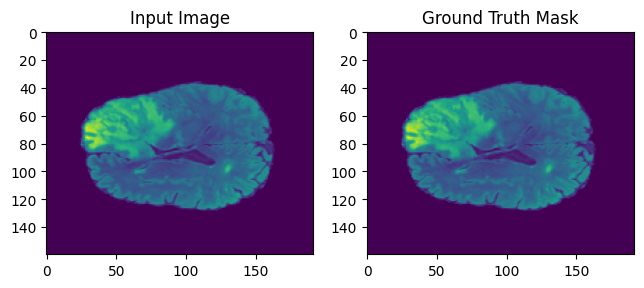

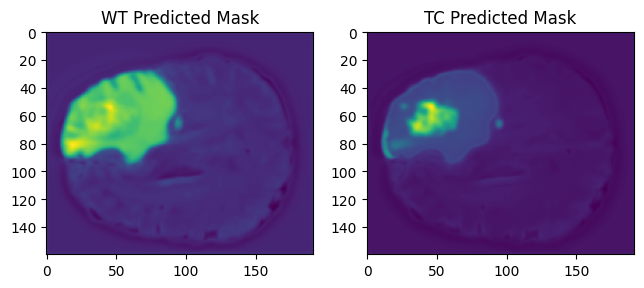

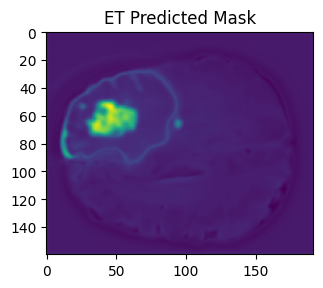

In [149]:
fig = plt.figure(figsize=(20, 10))

# Input Image
plt.subplot(151)
plt.imshow(r_input_img)
plt.title('Input Image')

# Ground Truth Mask
plt.subplot(152)
plt.imshow(r_input_seg)
plt.title('Ground Truth Mask')
plt.show()

fig = plt.figure(figsize=(20, 10))
# WT Predicted Mask
plt.subplot(153)
plt.imshow(pred_WT)
plt.title('WT Predicted Mask')

# TC Predicted Mask
plt.subplot(154)
plt.imshow(pred_TC)
plt.title('TC Predicted Mask')


fig = plt.figure(figsize=(20, 10))
# ET Predicted Mask
plt.subplot(155)
plt.imshow(pred_ET)
plt.title('ET Predicted Mask')

plt.show()
